In [1]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np 
from scipy.signal import welch
from detect_peaks import detect_peaks
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import entropy #seems non beneficial
from scipy.signal import hilbert

In [2]:
#Import Machine Learning Libraries
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
"""
Begin function declarations
"""
def BearingInfomation(n,N,Bd,Pd,phi):
    xx = Bd/Pd*np.cos(phi)
    BPFI = (N/2)*(1 + xx)*n
    BPFO = (N/2)*(1 - xx)*n
    BSF = (Pd/(2*Bd))*(1-(xx)**2)*n
    FTF= (1/2)*(1 - xx)*n
    x = {
        "BPFI": BPFI,
        "BPFO": BPFO,
        "BSF":  BSF,
        "FTF":  FTF
    }
    return x

In [4]:
def RemoveDCOffset(sig):
    m = sig - np.mean(sig)
    return m

In [5]:
def FourierTransform(comb_sig, T, N, f_s):
    #Fast Fourier Transform
    #number_of_time_samples = len(t)
    number_of_time_samples = N
    frq = np.arange(number_of_time_samples)/(Tmax)# two sides frequency range
    frq = frq[range(int(number_of_time_samples/(2)))] # one side frequency range
    Y = abs(np.fft.fft(comb_sig))/number_of_time_samples # fft computing and normalization
    Y = Y[range(int(number_of_time_samples/2))]
    #End fft
    x = {
        "Frequency":frq,
        "Freq. Amp.": Y
        }
    return x

In [6]:
def get_psd_values(comb_sig, T, N, fs):
    frq, psd_values = welch(comb_sig, fs=fs)
    x = {
        "Frequency":frq,
        "PSD": psd_values
        }
    return x

In [7]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(comb_sig, T, N, f_s):
    autocorr_values = autocorr(comb_sig)
    x_values = np.array([T * jj for jj in range(0, N)])
    x = {
        "X Values":x_values,
        "Autocorr Values": autocorr_values
        }
    return x

In [8]:
def TimeDomainInformation(comb_sig, T, N, f_s):
    x = {
        "RMS": np.mean(comb_sig**2),
        "STD": np.std(comb_sig),
        "Mean": np.mean(comb_sig),
        "Max": np.max(comb_sig),
        "Min": np.min(comb_sig),
        "Peak-to-Peak": (np.max(comb_sig) - np.min(comb_sig)),
        "Max ABS": np.max(abs(comb_sig)),
        "Kurtosis": kurtosis(comb_sig),
        "Skew": skew(comb_sig),
    }

    return x

In [9]:
def GetSortedPeak(frq,comb_sig, T, N, f_s):
    max_peak_height = 0.1 * np.nanmax(comb_sig)
    threshold = 0.05 * np.nanmax(comb_sig)
    #Get indices of peak
    peak = detect_peaks(comb_sig,edge = 'rising',mph = max_peak_height, mpd = 2, threshold = threshold )
    
    m = []
    mm = []
    for i in peak:
        m.append(comb_sig[i]) 
        mm.append(frq[i])

    mmm = np.argsort(m)
    n = []
    nn = []
    for i in mmm:
        n.append(m[i])
        nn.append(mm[i])

    n  = n[::-1]
    nn = nn[::-1]

    return n, nn

In [10]:
def FrequencyDomainInformation(comb_sig, T, N, f_s):
    x1 = FourierTransform(comb_sig, T, N, f_s)
    x2 = get_psd_values(comb_sig, T, N, f_s)
    x3 = get_autocorr_values(comb_sig, T, N, f_s)
    FTamp,FTfreq = GetSortedPeak(x1['Frequency'],x1['Freq. Amp.'], T, N, f_s)
    PSDamp,PSDfreq = GetSortedPeak(x2['Frequency'],x2['PSD'], T, N, f_s)
    Cor,CorTime = GetSortedPeak(x3['X Values'],x3['Autocorr Values'], T, N, f_s)
    
    while len(FTamp) <= 5:
        FTamp.append(['-999'])
    while len(FTfreq) <= 5:
        FTfreq.append(['-999'])
    while len(PSDamp) <= 5:
        PSDamp.append(['-999'])
    while len(PSDfreq) <= 5:
        PSDfreq.append(['-999'])
    while len(Cor) <= 5:
        Cor.append(['-999'])
    while len(CorTime) <= 5:
        CorTime.append(['-999'])
    
    x = {
        "FFT Frq @ Peak 1": FTfreq[0],
        "FFT Frq @ Peak 2": FTfreq[1],
        "FFT Frq @ Peak 3": FTfreq[2],
        "FFT Frq @ Peak 4": FTfreq[3],
        "FFT Frq @ Peak 5": FTfreq[4],
        "FFT Amp @ Peak 1": FTamp[0],
        "FFT Amp @ Peak 2": FTamp[1],
        "FFT Amp @ Peak 3": FTamp[2],
        "FFT Amp @ Peak 4": FTamp[3],
        "FFT Amp @ Peak 5": FTamp[4],
        "PSD Frq @ Peak 1": PSDfreq[0],
        "PSD Frq @ Peak 2": PSDfreq[1],
        "PSD Frq @ Peak 3": PSDfreq[2],
        "PSD Frq @ Peak 4": PSDfreq[3],
        "PSD Frq @ Peak 5": PSDfreq[4],
        "PSD Amp @ Peak 1": PSDamp[0],
        "PSD Amp @ Peak 2": PSDamp[1],
        "PSD Amp @ Peak 3": PSDamp[2],
        "PSD Amp @ Peak 4": PSDamp[3],
        "PSD Amp @ Peak 5": PSDamp[4],
        "Autocorrelate Time @ Peak 1": CorTime[0],
        "Autocorrelate Time @ Peak 2": CorTime[1],
        "Autocorrelate Time @ Peak 3": CorTime[2],
        "Autocorrelate Time @ Peak 4": CorTime[3],
        "Autocorrelate Time @ Peak 5": CorTime[4],
        "Autocorrelate @ Peak 1": Cor[0],
        "Autocorrelate @ Peak 2": Cor[1],
        "Autocorrelate @ Peak 3": Cor[2],
        "Autocorrelate @ Peak 4": Cor[3],
        "Autocorrelate @ Peak 5": Cor[4]
    }
    return x

In [11]:
def getAbsoluteTime(file):
    year   = int(file[0:4])
    month  = int(file[5:7])
    day    = int(file[8:10])
    hour   = int(file[11:13])
    minute = int(file[14:16])
    second = int(file[17:19])
    x = second + 60*minute + 60*60*hour + 24*60*60*day + 31*24*60*60*(month - 10)
    return x

In [12]:
"""
http://mkalikatzarakis.eu/wp-content/uploads/2018/12/IMS_dset.html
Previous work done on this dataset states that seven different states of health were observed:

Early (initial run-in of the bearings)
Normal
Suspect (the health seems to be deteriorating)
Imminent failure (for bearings 1 and 2, which didn’t actually fail, but were severely worn out)
Inner race failure (bearing 3)
Rolling element failure (bearing 4)
Stage 2 failure (bearing 4)
For the first test (the one we are working on), the following labels have been proposed per file:

Bearing 1
early: 2003.10.22.12.06.24 - 2013.10.23.09.14.13
suspect: 2013.10.23.09.24.13 - 2003.11.08.12.11.44 (bearing 1 was in suspicious health from the beginning, but showed some self-healing effects)
normal: 2003.11.08.12.21.44 - 2003.11.19.21.06.07
suspect: 2003.11.19.21.16.07 - 2003.11.24.20.47.32
imminent failure: 2003.11.24.20.57.32 - 2003.11.25.23.39.56

Bearing 2
early: 2003.10.22.12.06.24 - 2003.11.01.21.41.44
normal: 2003.11.01.21.51.44 - 2003.11.24.01.01.24
suspect: 2003.11.24.01.11.24 - 2003.11.25.10.47.32
imminent failure: 2003.11.25.10.57.32 - 2003.11.25.23.39.56

Bearing 3
early: 2003.10.22.12.06.24 - 2003.11.01.21.41.44
normal: 2003.11.01.21.51.44 - 2003.11.22.09.16.56
suspect: 2003.11.22.09.26.56 - 2003.11.25.10.47.32
Inner race failure: 2003.11.25.10.57.32 - 2003.11.25.23.39.56

Bearing 4
early: 2003.10.22.12.06.24 - 2003.10.29.21.39.46
normal: 2003.10.29.21.49.46 - 2003.11.15.05.08.46
suspect: 2003.11.15.05.18.46 - 2003.11.18.19.12.30
Rolling element failure: 2003.11.19.09.06.09 - 2003.11.22.17.36.56
Stage 2 failure: 2003.11.22.17.46.56 - 2003.11.25.23.39.56
"""

def StateInformation(comb_sig, T, N, f_s,file,BearingNum):
    
    absolutetime = getAbsoluteTime(file)
    #in seconds don't include years taking 10 as the start month
    
    #Bearing 1 transitions
    b1e2s  = getAbsoluteTime("2013.10.23.09.14.13")
    b1s2n  = getAbsoluteTime("2003.11.08.12.11.44")
    b1n2s  = getAbsoluteTime("2003.11.19.21.06.07")
    b1s2i  = getAbsoluteTime("2003.11.24.20.47.32")
    
    #Bearing 2 transitions
    b2e2n  = getAbsoluteTime("2003.11.01.21.41.44")
    b2n2s  = getAbsoluteTime("2003.11.24.01.01.24")
    b2s2i  = getAbsoluteTime("2003.11.25.10.47.32")
    
    #Bearing 3 transitions
    b3e2n  = getAbsoluteTime("2003.11.01.21.41.44")
    b3n2s  = getAbsoluteTime("2003.11.22.09.16.56")
    b3s2irf  = getAbsoluteTime("2003.11.25.10.47.32")
    
    #Bearing 4 transitions
    b4e2n  = getAbsoluteTime("2003.10.29.21.39.46")
    b4n2s  = getAbsoluteTime("2003.11.15.05.08.46")
    b4s2r  = getAbsoluteTime("2003.11.18.19.12.30")
    b4r2f  = getAbsoluteTime("2003.11.22.17.36.56")
    
    m = "ERROR"
    if BearingNum == 1:
        if absolutetime   <= b1e2s:
            m = "Early"
        elif absolutetime <= b1s2n:
            m = "Suspect"
        elif absolutetime <= b1n2s:
            m = "Normal"
        elif absolutetime <= b1s2i:
            m = "Suspect"
        elif absolutetime > b1s2i:
            m = "Imminent Failure"
    elif BearingNum == 2:
        if absolutetime   <= b2e2n:
            m = "Early"
        elif absolutetime <= b2n2s:
            m = "Normal"
        elif absolutetime <= b2s2i:
            m = "Suspect"
        elif absolutetime > b2s2i:
            m = "Imminent Failure" 
    elif BearingNum == 3:
        if absolutetime   <= b3e2n:
            m = "Early"
        elif absolutetime <= b3n2s:
            m = "Normal"
        elif absolutetime <= b3s2irf:
            m = "Suspect"
        elif absolutetime >= b3s2irf:
            m = "Inner Race Failure"   
    elif BearingNum == 4:
        if absolutetime   <= b4e2n:
            m = "Early"
        elif absolutetime <= b4n2s:
            m = "Normal"
        elif absolutetime <= b4s2r:
            m = "Suspect"
        elif absolutetime <= b4r2f:
            m = "Rolling Element Failure"
        elif absolutetime > b4r2f:
            m = "Stage 2 Failure"
    else:
        m = "ERROR"
        
    x = {
        "State": m
    }
    return x

In [13]:
#Bearing 1 transitions
b1e2s  = getAbsoluteTime("2013.10.23.09.14.13")
b1s2n  = getAbsoluteTime("2003.11.08.12.11.44")
b1n2s  = getAbsoluteTime("2003.11.19.21.06.07")
b1s2i  = getAbsoluteTime("2003.11.24.20.47.32")

#Bearing 2 transitions
b2e2n  = getAbsoluteTime("2003.11.01.21.41.44")
b2n2s  = getAbsoluteTime("2003.11.24.01.01.24")
b2s2i  = getAbsoluteTime("2003.11.25.10.47.32")

#Bearing 3 transitions
b3e2n  = getAbsoluteTime("2003.11.01.21.41.44")
b3n2s  = getAbsoluteTime("2003.11.22.09.16.56")
b3s2irf  = getAbsoluteTime("2003.11.25.10.47.32")

#Bearing 4 transitions
b4e2n  = getAbsoluteTime("2003.10.29.21.39.46")
b4n2s  = getAbsoluteTime("2003.11.15.05.08.46")
b4s2r  = getAbsoluteTime("2003.11.18.19.12.30")
b4r2f  = getAbsoluteTime("2003.11.22.17.36.56")

In [14]:
def MotorInformation(comb_sig, T, N, f_s):
    x = {
        "Motor Type AC(1)-DC(0)": 1,
        "Shaft Speed [Hz]": 2000/60
    }
    return x

In [15]:
def getCompleteDataFrame(sig,Tmax,NumberOfSamples,SampleFrequency,n,N,Bd,Pd,phi,file,BearingNum):
    sig = RemoveDCOffset(sig)
    BearingInfo = BearingInfomation(n,N,Bd,Pd,phi)
    TimeDomainInfo = TimeDomainInformation(sig,Tmax,NumberOfSamples,SampleFrequency)
    FrequecyDomainInfo = FrequencyDomainInformation(sig,Tmax,NumberOfSamples,SampleFrequency)
    StateInfo = StateInformation(sig,Tmax,NumberOfSamples,SampleFrequency,file,BearingNum)
    MotorInfo = MotorInformation(sig,Tmax,NumberOfSamples,SampleFrequency)
    Features = {**StateInfo,**MotorInfo,**BearingInfo,**TimeDomainInfo,**FrequecyDomainInfo}
    Features = pd.DataFrame(Features, index=[0])
    return Features  

In [16]:
def getPlot(X,Y,xlabel,ylabel,Title):
    fig = plt.figure()
    plt.plot(X,Y,'r')
    plt.xlabel(ylabel)
    plt.ylabel(ylabel)
    plt.title(Title)
    plt.grid(True)
    return fig

In [17]:
"""
END of Function Declaration
Begin Extracting Data
"""

'\nEND of Function Declaration\nBegin Extracting Data\n'

In [18]:
HomeDirectory = "/Users/tbryan/Desktop/9 2019 Fall/ECEN 403/Programming/Programs_October13"
os.chdir(HomeDirectory)
print(os.getcwd())
os.chdir('Data')
os.chdir('IMS')
directory = sorted(os.listdir('1st_test'))
directory.remove(".DS_Store")
os.chdir('1st_test')
print(directory[0])

/Users/tbryan/Desktop/9 2019 Fall/ECEN 403/Programming/Programs_October13
2003.10.22.12.06.24


In [19]:
data = pd.read_table(directory[0],header = None)
data.columns = ['b1x','b1y','b2x','b2y','b3x','b3y','b4x','b4y']
print(data.head())

     b1x    b1y    b2x    b2y    b3x    b3y    b4x    b4y
0 -0.022 -0.039 -0.183 -0.054 -0.105 -0.134 -0.129 -0.142
1 -0.105 -0.017 -0.164 -0.183 -0.049  0.029 -0.115 -0.122
2 -0.183 -0.098 -0.195 -0.125 -0.005 -0.007 -0.171 -0.071
3 -0.178 -0.161 -0.159 -0.178 -0.100 -0.115 -0.112 -0.078
4 -0.208 -0.129 -0.261 -0.098 -0.151 -0.205 -0.063 -0.066


In [20]:
b1x = np.transpose(data.values[:,0])
b1y = np.transpose(data.values[:,1])
b2x = np.transpose(data.values[:,2])
b2y = np.transpose(data.values[:,3])
b3x = np.transpose(data.values[:,4])
b3y = np.transpose(data.values[:,5])
b4x = np.transpose(data.values[:,6])
b4y = np.transpose(data.values[:,7])
x = data.index.values
print(x)

[    0     1     2 ... 20477 20478 20479]


In [21]:
"""
n: Shaft rotational speed [Hz] 2000 rpm
N: No. of rolling elements [-] 16
Bd: Diameter of a rolling element [mm] 0.331 in
Pd: Pitch diameter [mm] 2.815 in
ϕ: Contact angle [rad] 15.17*pi/180
"""

"""
The fundamental parameters are a constant for IMS Dataset
"""
n = 2000 / 60
N = 16
Bd = 0.331*254
Pd = 2.815*254
phi = 15.17 * np.pi / 180

"""
The sampling parameters were also a constant for the IMS Dataset

Going forward we will not give the user's flexibility as to the run time
i.e. we determine the frequency resolution
i.e. we don't want to make the file size to long

"""
SampleFrequency = 20000
NumberOfSamples = len(data.index.values)
dt = 1/SampleFrequency
Tmax = dt*NumberOfSamples
t = np.arange(0,Tmax,dt) #same as x*dt


In [22]:
'''
This cell is testing purposes
'''

TEST = getCompleteDataFrame(b1x,Tmax,NumberOfSamples,SampleFrequency,n,N,Bd,Pd,phi,directory[0],1)

year   = int(directory[0][0:4])
month  = int(directory[0][5:7])
day    = int(directory[0][8:10])
hour   = int(directory[0][11:13])
minute = int(directory[0][14:16])
second = int(directory[0][17:19])
print(directory[0])
print(year, month, day, hour, minute, second)

2003.10.22.12.06.24
2003 10 22 12 6 24


In [25]:
"""m1 = []
m2 = []
m3 = []
m4 = []
i = 0
while i < len(directory):
#while i < 20:
    data = pd.read_table(directory[i],header = None)
    B1X = getCompleteDataFrame(np.transpose(data.values[:,0]),Tmax,NumberOfSamples,SampleFrequency,n,N,Bd,Pd,phi,directory[i],1)
    B2X = getCompleteDataFrame(np.transpose(data.values[:,2]),Tmax,NumberOfSamples,SampleFrequency,n,N,Bd,Pd,phi,directory[i],2)
    B3X = getCompleteDataFrame(np.transpose(data.values[:,4]),Tmax,NumberOfSamples,SampleFrequency,n,N,Bd,Pd,phi,directory[i],3)
    B4X = getCompleteDataFrame(np.transpose(data.values[:,6]),Tmax,NumberOfSamples,SampleFrequency,n,N,Bd,Pd,phi,directory[i],4)
    ColumnTitle = B1X.columns
    m1.append(B1X.values[0,:])
    m2.append(B2X.values[0,:])
    m3.append(B3X.values[0,:])
    m4.append(B4X.values[0,:])
    i += 1

B1X = pd.DataFrame(m1,columns = ColumnTitle)
B2X = pd.DataFrame(m2,columns = ColumnTitle)
B3X = pd.DataFrame(m3,columns = ColumnTitle)
B4X = pd.DataFrame(m4,columns = ColumnTitle)
TD = B1X
TD = TD.append(B2X)
TD = TD.append(B3X)
TD = TD.append(B4X)
TD.to_csv("DELETE.csv")
print("Finished")

os.chdir(HomeDirectory)
"""
print("Finished")

Finished


In [26]:
#Get Training Data
HomeDirectory = "/Users/tbryan/Desktop/9 2019 Fall/ECEN 403/Programming/Programs_October13"
os.chdir(HomeDirectory)
directory = os.listdir(HomeDirectory)
TrainingDataFile = "DELETE.csv"
for file in directory:
    if file == TrainingDataFile:
        dataset = pd.read_csv(file,header = 0,index_col = 0)

X = dataset.values[:,1:(dataset.shape[1]-1)]
Y = dataset.values[:,0]
validation_size = 0.20
seed = 6
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)   


In [27]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.9263768115942029
                         precision    recall  f1-score   support

                  Early       0.98      0.92      0.95       276
       Imminent Failure       1.00      0.80      0.89        20
     Inner Race Failure       0.90      1.00      0.95         9
                 Normal       0.91      0.97      0.94       879
Rolling Element Failure       0.98      0.94      0.96        63
        Stage 2 Failure       0.94      0.98      0.96        64
                Suspect       0.93      0.84      0.88       414

            avg / total       0.93      0.93      0.93      1725



4


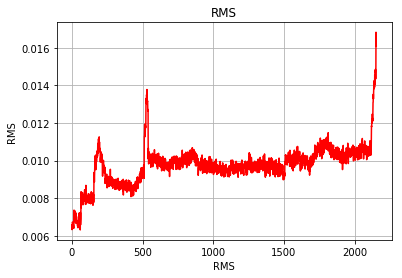

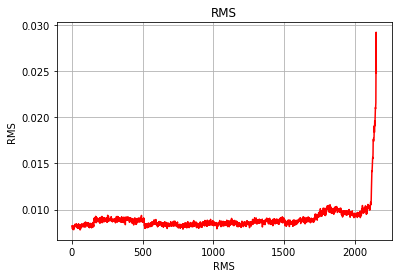

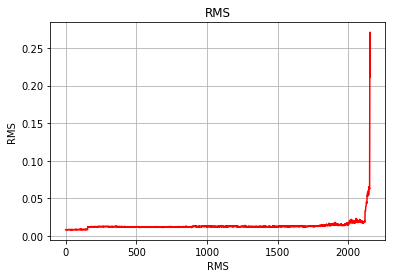

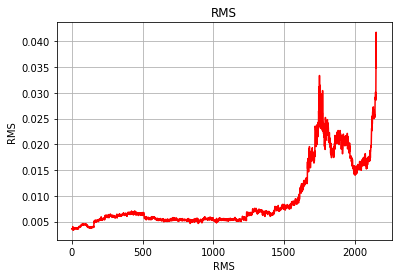

In [89]:
"Graph for Brendan"
figs = []
figs.append(getPlot(dataset.index[0:2155],dataset["RMS"][0:2155].values,"Sample #","RMS","RMS"))
figs.append(getPlot(dataset.index[2156:4311],dataset["RMS"][2156:4311].values,"Sample #","RMS","RMS"))
figs.append(getPlot(dataset.index[4312:6467],dataset["RMS"][4312:6467].values,"Sample #","RMS","RMS"))
figs.append(getPlot(dataset.index[6468:8623],dataset["RMS"][6468:8623].values,"Sample #","RMS","RMS"))

In [58]:
#Begin Selecting Features using Chi Square
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_selection import RFE

"""
test = SelectKBest(score_func=chi2, k=4)
test.fit(X_train,Y_train)
print(test)
print(chi2(X_train,Y_train))
"""

clf = RandomForestClassifier(n_estimators=1000)
rfe = RFE(clf, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

KeyboardInterrupt: 

In [83]:
class MyPopUp:
    def __init__(self, realpart, imagpart,m):
        self.r = realpart
        self.i = imagpart
        self.m = m
    
    def update(self,string1):
        self.m = string1
        
x = MyPopUp(realpart = 3, imagpart = 4, m = "Hello")
print(x.m)
x.m = "Test"
print(x.m)
x.update("t1")
print(x.m)

Hello
Test
t1


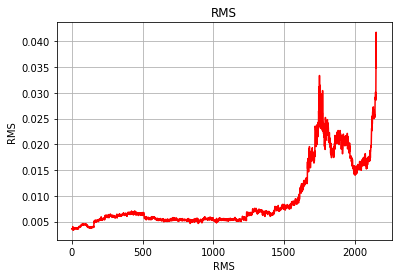

In [88]:
figs[3]